# Amazon: 20 years of reviews

# I. Data wrangling

In [1]:
from os import walk
import pandas as pd
import re
import pickle

from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DateType

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sql_context = SQLContext(sc)

In [16]:
# Directory of the .tsv.gz files (original dataset approx. 33G)
DATA_DIR = './data/'

# Directory of the reduced datasets in parquet format (approx. 2.6 GB)
PARQUET_DIR = './parquet/'

The Amazon review dataset consists of set of tab separated csv files with the following columns:
 - marketplace (country id, 2 digits), 
 - customer_id (a unique reviewer identifier),
 - review_id,
 - product_id,
 - product_parent (a unique product identifier),
 - product_title,
 - product_category,
 - star_rating (0-5 scale),
 - helpful_votes (number of votes saying that review is useful)
 - total_votes (number of votes in total),
 - vine (true/false if the review was written as part of Vine program),
 - verfied_purchase (true/false),
 - review_headline (review title),
 - review_body (text),
 - review_date.
 
 Here comes some sample data:

In [3]:
sample_pd = pd.read_csv('sample_us.tsv', delimiter='\t', error_bad_lines=False)
sample_pd.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,18778586,RDIJS7QYB6XNR,B00EDBY7X8,122952789,Monopoly Junior Board Game,Toys,5,0,0,N,Y,Five Stars,Excellent!!!,2015-08-31
1,US,24769659,R36ED1U38IELG8,B00D7JFOPC,952062646,56 Pieces of Wooden Train Track Compatible wit...,Toys,5,0,0,N,Y,Good quality track at excellent price,Great quality wooden track (better than some o...,2015-08-31
2,US,44331596,R1UE3RPRGCOLD,B002LHA74O,818126353,Super Jumbo Playing Cards by S&S Worldwide,Toys,2,1,1,N,Y,Two Stars,Cards are not as big as pictured.,2015-08-31
3,US,23310293,R298788GS6I901,B00ARPLCGY,261944918,Barbie Doll and Fashions Barbie Gift Set,Toys,5,0,0,N,Y,my daughter loved it and i liked the price and...,my daughter loved it and i liked the price and...,2015-08-31
4,US,38745832,RNX4EXOBBPN5,B00UZOPOFW,717410439,Emazing Lights eLite Flow Glow Sticks - Spinni...,Toys,1,1,1,N,Y,DONT BUY THESE!,Do not buy these! They break very fast I spun ...,2015-08-31


### Filter data out and save to parquet

As first step, we will gather all filenames in order to filter out the relevant information and then save resulting dataframes in more convenient parquet format. The parquet format can be read by either pyspark or pandas. Please merge different volumes of the data of the same category (e.g. Books has volumes 1.00, 1.01 and 1.02; they should be merged all into version 1.00). This can be easily done using `cat` command.

In [12]:
# Get list of all files in DATA_DIR
review_files = []
for (dirpath, dirnames, filenames) in walk(DATA_DIR):
    review_files.extend(filenames)
    break
    
# Put them in a DataFrame
df_all_reviews = pd.DataFrame({'filename' : review_files})
df_all_reviews.head()

,filename
0,amazon_reviews_us_Shoes_v1_00.tsv.gz
1,amazon_reviews_us_Mobile_Apps_v1_00.tsv.gz
2,amazon_reviews_us_Personal_Care_Appliances_v1_...
3,amazon_reviews_multilingual_US_v1_00.tsv.gz
4,amazon_reviews_us_Home_Improvement_v1_00.tsv.gz


The full dataset contains multilingual nad US reviews. We are only interested in the US reviews.

In [13]:
# Filter out only US reviews
df_us_reviews = df_all_reviews[df_all_reviews.filename.str.contains("_us_")].copy()
df_us_reviews.head()

,filename
0,amazon_reviews_us_Shoes_v1_00.tsv.gz
1,amazon_reviews_us_Mobile_Apps_v1_00.tsv.gz
2,amazon_reviews_us_Personal_Care_Appliances_v1_...
4,amazon_reviews_us_Home_Improvement_v1_00.tsv.gz
5,amazon_reviews_us_Digital_Video_Download_v1_00...


In [14]:
# Find category name
df_us_reviews['category'] = df_us_reviews['filename'].apply(lambda s: re.search(r'us_(.*?)_v', s).group(1)).head()
df_us_reviews.head()

,filename,category
0,amazon_reviews_us_Shoes_v1_00.tsv.gz,Shoes
1,amazon_reviews_us_Mobile_Apps_v1_00.tsv.gz,Mobile_Apps
2,amazon_reviews_us_Personal_Care_Appliances_v1_...,Personal_Care_Appliances
4,amazon_reviews_us_Home_Improvement_v1_00.tsv.gz,Home_Improvement
5,amazon_reviews_us_Digital_Video_Download_v1_00...,Digital_Video_Download


### Save metadata to parquet

Now, let's choose columns we want to analyse and save resulting data frames in parquet format.

In [15]:
# First, define a function that properly reads a tsv file to pyspark DF
def read_tsv_to_pyspark_DF(filename):
    schema = StructType([
        StructField('marketplace', StringType(), True), #2 letter country code
        StructField('customer_id', IntegerType(), True), #author identifier
        StructField('review_id', StringType(), True), #unique review ID
        StructField('product_id', StringType(), True), # unique product ID
        StructField('product_parent', IntegerType(), True), # product identifier to be used to aggregate reviews for a product
        StructField('product_title', StringType(), True),
        StructField('product_category', StringType(), True),
        StructField('star_rating', IntegerType(), True), # 1-5 star rating 
        StructField('helpful_votes', IntegerType(), True), # positive votes for the review
        StructField('total_votes', IntegerType(), True), # total votes for the review
        StructField('vine', StringType(), True), # review is part of Vine Program
        StructField('verfied_purchase', StringType(), True), # Review is on Verified Purchase
        StructField('review_headline', StringType(), True), # title of the review
        StructField('review_body', StringType(), True), # text
        StructField('review_date', DateType(), True)]) # date of review 

    return sql_context.read.option('sep', '\t').csv(filename, schema=schema, header=True)

We choose the relevant information for a general analysis of the reviews.

In [17]:
# We choose columns here
columns = ['customer_id', 'review_id', 'product_parent',
          'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'review_date']

In [ ]:
# Iterate over rows and create parquets
for index, row in df_us_reviews.iterrows():
    # Read tsv file
    df = read_tsv_to_pyspark_DF(DATA_DIR + row['filename'])

    # Filter out columns
    df_filtered = df.select(columns).dropna()
    
    # Write to parquet
    df_filtered.write.parquet(PARQUET_DIR + row['category'] + '.parquet.gzip', compression='gzip')

### Create parquets with reviews

The following code extracts reviews texts as separate DataFrames. Entries can be matched with metadata using review_id. We will do text analysis only on a chosen category.

In [19]:
columns_review_text = ['review_id', 'review_headline', 'review_body']

In [ ]:
# Iterate over rows and create parquets
for index, row in df_us_reviews.iterrows():
    # Read tsv file
    df = read_tsv_to_pyspark_DF(DATA_DIR + row['filename'])

    # Filter out columns
    df_filtered = df.select(columns_review_text).dropna()
    
    # Write to parquet
    df_filtered.write.parquet(PARQUET_DIR + row['category'] + '_text.parquet.gzip', compression='gzip')

# II. Data analysis

In [25]:
import pickle
import pandas as pd
import numpy as np
import fastparquet
import pyarrow # we need both
import matplotlib.pyplot as plt
%matplotlib inline

### Load the data

In [26]:
# The parquet files created by the code above are available here:
# https://drive.google.com/open?id=1CkC4OMzkUiwjt7un_K6jhMlBVD1L4t5o
# please download it and extract to the right directory.
PARQUET_DIR = './parquet/'

In [27]:
#US reviews by category
with open('category_reviews.pickle', 'rb') as file:
    category_reviews = pickle.load(file)

In [28]:
reviews = category_reviews[['category']]
reviews.head()

,category
0,Shoes
1,Mobile_Apps
2,Personal_Care_Appliances
3,Home_Improvement
4,Digital_Video_Download


In [29]:
def parquet_filename(category):
    """
    Returns the filename of parquet corresponding to the given caterogy.
    """
    return PARQUET_DIR + category + '.parquet.gzip'

# Use this function to load data!
def read_DataFrame(category):
    """
    Returns DataFrame corresponding to given category
    """
    # we specify the engine here, we use pyarrow because it is smarter
    return pd.read_parquet(parquet_filename(category), engine='pyarrow')

In [30]:
read_DataFrame('Shoes').head()

,customer_id,review_id,product_parent,product_category,star_rating,helpful_votes,total_votes,review_date
0,18069663,R3P2HIOQCIN5ZU,265024781,Shoes,1,0,0,2015-08-31
1,16251825,R12VVR0WH5Q24V,259035853,Shoes,5,0,0,2015-08-31
2,20381037,RNCCKB6TV5EEF,666066660,Shoes,4,0,0,2015-08-31
3,108364,R2NZXYIVCGB13W,448483263,Shoes,5,0,6,2015-08-31
4,45449350,R2EQ1TG9IT3OEQ,7853171,Shoes,3,0,0,2015-08-31


In [17]:
# we need fastparquet here because pyarrow cannot load the long strings
# However, fastparquet needs a full path, which is not a big problem as we analyse only some text sets

# it's ugly but it works
pd.read_parquet(PARQUET_DIR+'Wireless_text.parquet.gzip/'+'part-00000-321618fb-c8f4-49c2-a9bb-a4afbf170e56-c000.gz.parquet', engine='fastparquet').head()

,review_id,review_headline,review_body
0,R3W4P9UBGNGH1U,"Looks good, functions meh",2 issues - Once I turned on the circle apps ...
1,R15V54KBMTQWAY,A fun little gadget,"I’m embarrassed to admit that until recently, ..."
2,RY8I449HNXSVF,Five Stars,Fits iPhone 6 well
3,R18TLJYCKJFLSR,Great charger,Great charger. I easily get 3+ charges on a S...
4,R1NK26SWS53B8Q,Five Stars,Great for the price :-)


### Explore categories

#### Total reviews number

Let's check what category has the most reviews.

In [12]:
def review_count(category):
    """
    Count all reviews
    """
    return read_DataFrame(category).shape[0]

/anaconda3/envs/ada/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


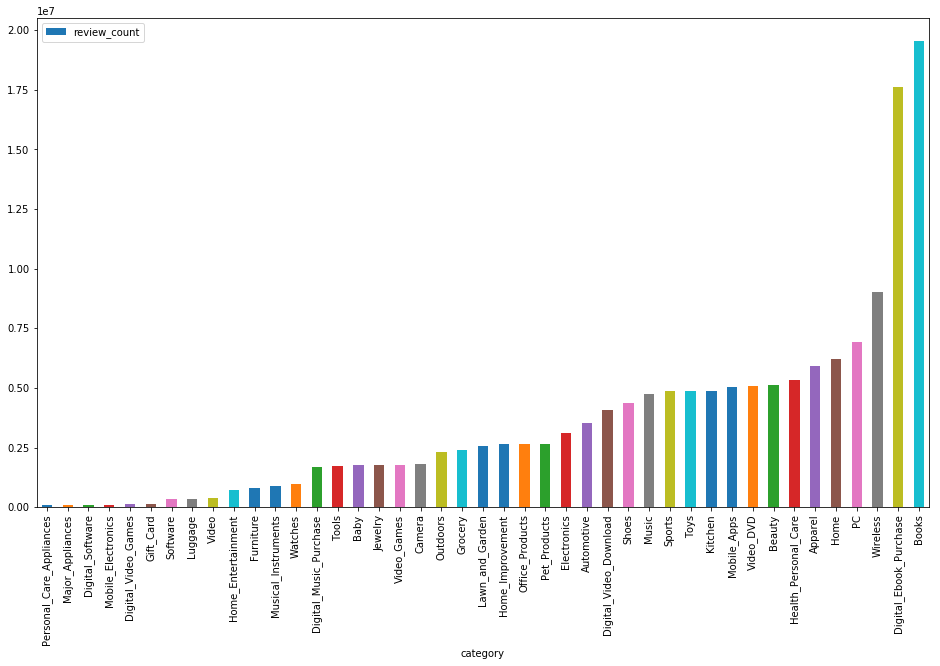

In [13]:
reviews['review_count'] = reviews['category'].apply(review_count)
reviews.sort_values("review_count").plot.bar(x='category', y='review_count', figsize=(16,9))

Books and e-books accumulated the most reviews over the time. "New" categories such as wireless and PC also have many reviews.

#### Unique reviewed product count by category

/anaconda3/envs/ada/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


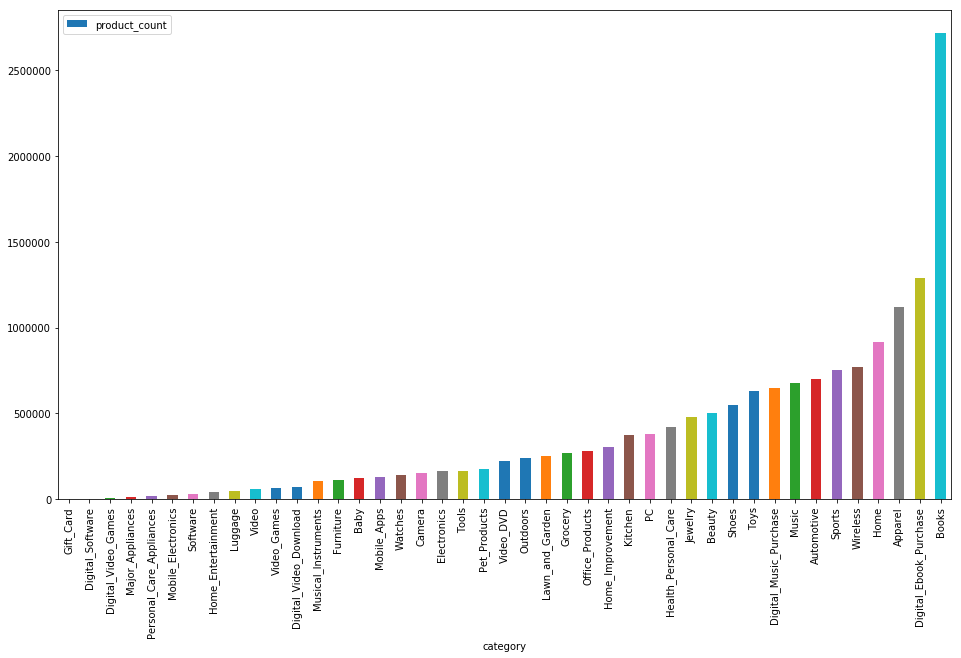

In [14]:
def product_count(category):
    """
    Count unique products
    """
    return read_DataFrame(category).product_parent.nunique()

reviews['product_count'] = reviews['category'].apply(product_count)
reviews.sort_values("product_count").plot.bar(x='category', y='product_count', figsize=(16,9))

In the books category there is the biggest number of reviewed products. Clearly, there are not many products in Gift cards.

#### Average number of reviews per product

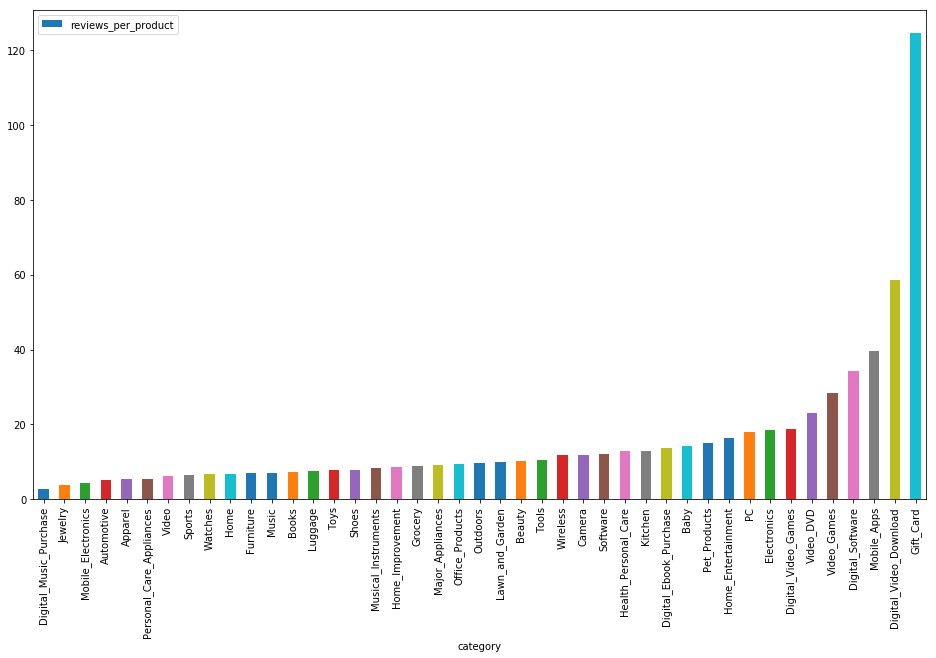

In [16]:
# How many reviews per product in average
reviews['reviews_per_product'] = reviews['review_count']/reviews['product_count']
reviews.sort_values('reviews_per_product').plot.bar(x='category', y='reviews_per_product', figsize=(16,9))

Gift card receive the most reviews per product. It is not surprising: they are not many but they are purchased - and reviewed - very often. It is a boring category, though. How a gift card review can be useful?

#### Mean rating of reviews

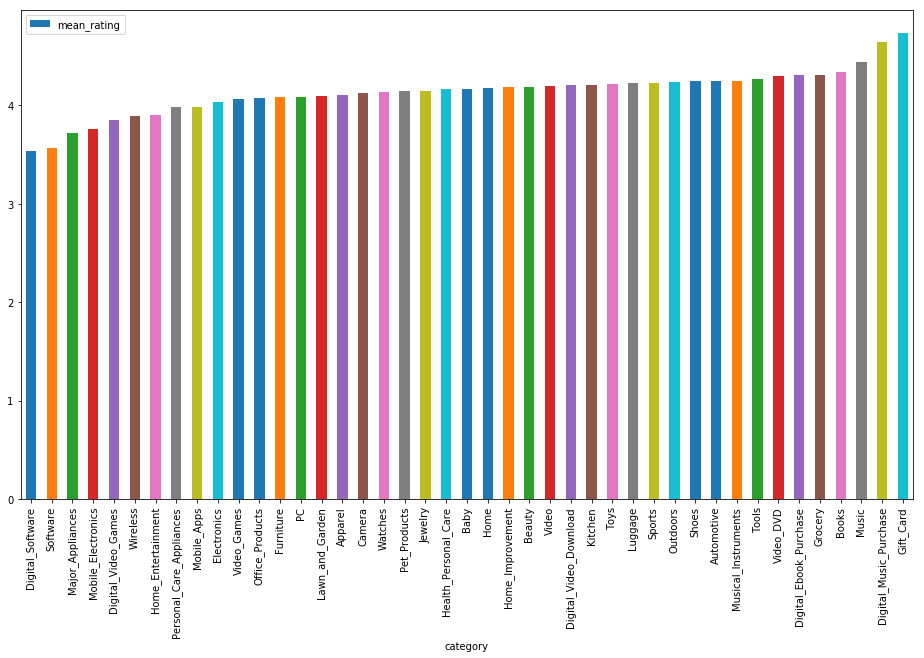

In [17]:
def mean_rating(category):
    """
    Return mean star rating of a category
    """
    return read_DataFrame(category).star_rating.mean()

reviews['mean_rating'] = reviews['category'].apply(mean_rating)
reviews.sort_values('mean_rating').plot.bar(x='category', y='mean_rating', figsize=(16,9))

At first sight, we can see that softwares are more subjected to contreverse regarding the ratings whereas music and books receive in general better grades.
Indeed, categories such as books may be biased in terms of reviews as the buyer is already interested in buying a book which is supposed to interest him. On the contrary, people buyin software or electronic devices may be more disappointed, hence handing out lower ratings.

This hypothese can help us in chosing a category to investigate review's reliability.

#### Variance of ratings

Variance of rating somehow quantifies the degree of controversy. It seems that software is the most controversial category. Gift card buyers are unanimously happy with their purchases.

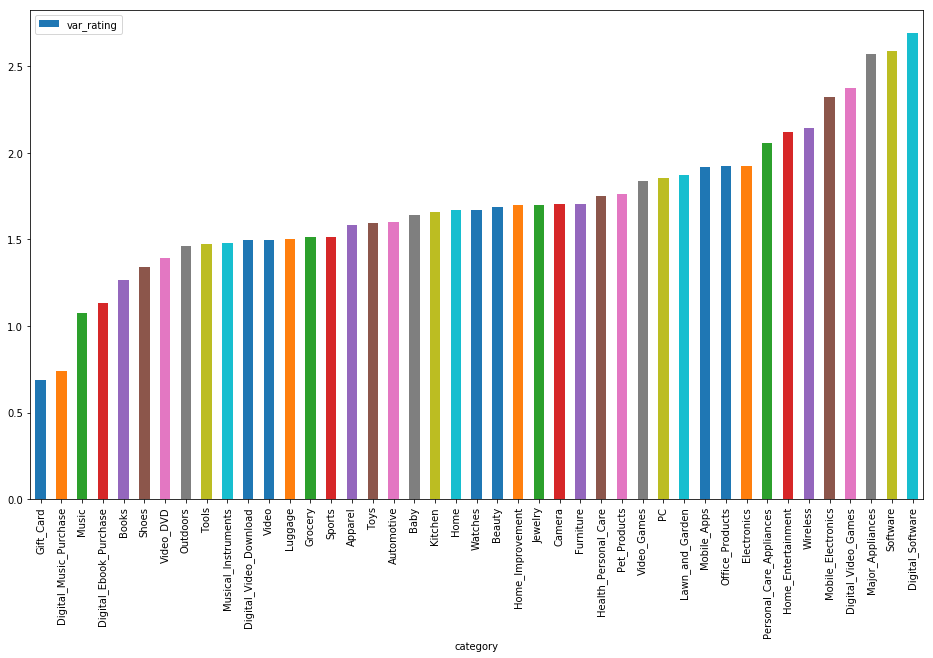

In [18]:
#Variance of raiting within category

def var_rating(category):
    """
    Return variance of raiting within category
    """
    return read_DataFrame(category).star_rating.var()

reviews['var_rating'] = reviews['category'].apply(var_rating)
reviews.sort_values('var_rating').plot.bar(x='category', y='var_rating', figsize=(16,9))

#### Mean usefulness score

We present the categories where readers appreciate more reviews. Digital products reviews seem to be less useful than tangible objects reviews.

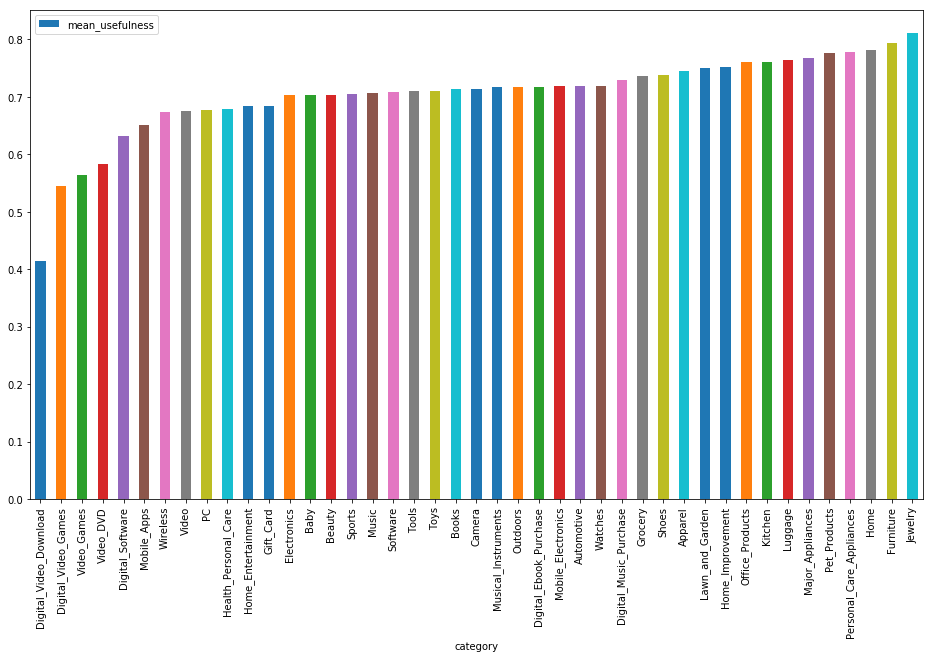

In [19]:
# Mean usefulness score of a category
def mean_usefulness(category):
    """
    Return mean helpful rate of a category
    """
    df = read_DataFrame(category)
    return np.mean(df.helpful_votes / df.total_votes)

reviews['mean_usefulness'] = reviews['category'].apply(mean_usefulness)
reviews.sort_values('mean_usefulness').plot.bar(x='category', y='mean_usefulness', figsize=(16,9))

#### Variance of usefulness

This measure describes how unanimous are the readers when they rate if reviews are useful or not.

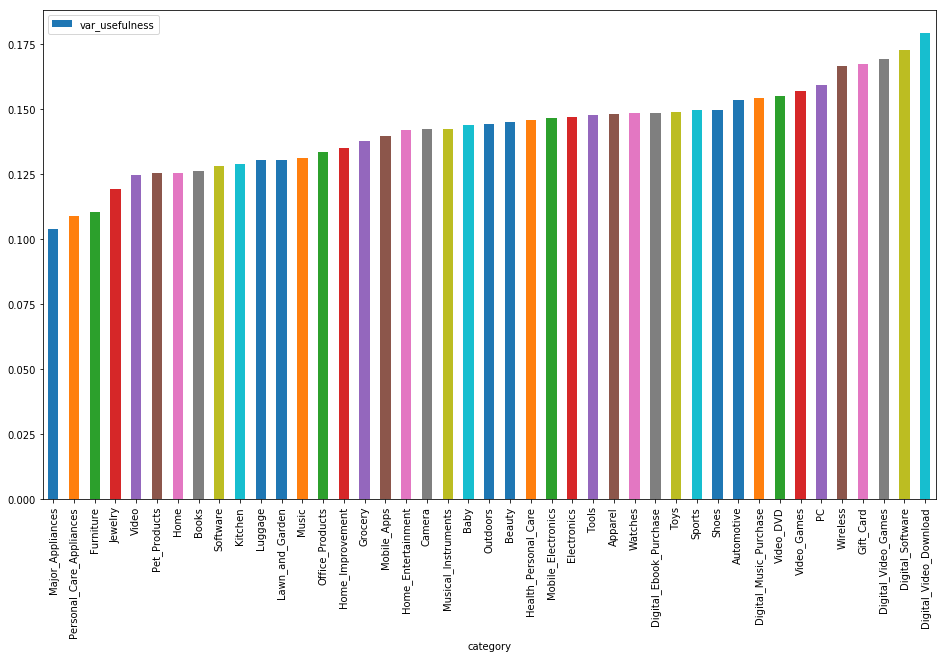

In [20]:
def var_usefulness(category):
    """
    Variance of helpful rate of a category
    """
    df = read_DataFrame(category)
    return np.var(df.helpful_votes / df.total_votes)

reviews['var_usefulness'] = reviews['category'].apply(var_usefulness)
reviews.sort_values('var_usefulness').plot.bar(x='category', y='var_usefulness', figsize=(16,9))

All the results are gathered here.

In [21]:
reviews.head()

,category,review_count,product_count,reviews_per_product,mean_rating,var_rating,mean_usefulness,var_usefulness
0,Shoes,4366761,551635,7.916033,4.241256,1.339806,0.738165,0.149615
1,Mobile_Apps,5033305,127061,39.613296,3.981599,1.917181,0.651378,0.139600
2,Personal_Care_Appliances,85978,15919,5.400967,3.977401,2.053911,0.777162,0.108649
3,Home_Improvement,2634428,303796,8.671701,4.182400,1.696582,0.751364,0.134908
4,Digital_Video_Download,4056597,69281,58.552807,4.201211,1.496933,0.414669,0.179085


## Temporal analysis

We will check how reviews evolved in time for some representative categories.

Either work on the entire categories:

In [ ]:
chosen_categories = ['Books', 'Wireless', 'PC', 'Home', 'Toys', 'Mobile_Apps', 'Beauty', 'Major_Appliances', 
                    'Personal_Care_Appliances', 'Furniture', 'Jewelry', 'Video', 'Pet_Products', 'Software', 
                    'Kitchen', 'Luggage', 'Lawn_and_Garden', 'Music', 'Office_Products', 'Home_Improvement', 
                    'Grocery', 'Home_Entertainment', 'Camera', 'Musical_Instruments', 'Baby', 'Outdoors',
                    'Health_Personal_Care', 'Mobile_Electronics', 'Electronics', 'Tools', 'Apparel', 'Watches',
                    'Digital_Ebook_Purchase', 'Sports', 'Shoes', 'Automotive', 'Digital_Music_Purchase',
                    'Video_DVD', 'Video_Games', 'Gift_Card', 'Digital_Video_Games', 'Digital_Software',
                    'Digital_Video_Download']

Either work on a subset:

In [22]:
chosen_categories = ['Books', 'Wireless', 'PC', 'Home', 'Toys', 'Mobile_Apps']

We define some generic functions

In [23]:
def temporal_analysis(chosen_categories, method):
    """
    Applies method to category and returns data frame with time evolution
    """
    df = pd.DataFrame()
    for category in chosen_categories:
        method(category, df)
    return df

In [24]:
def plot_temporal_evolution(chosen_categories, df):
    """
    Plots the "temporal" data frame
    """
    df.plot(y=chosen_categories, figsize=(16,10))

### Number of reviews by year

In [25]:
def count_reviews_by_year(category, df):
    df_read = read_DataFrame(category)
    df[category] = df_read.groupby(pd.DatetimeIndex(df_read['review_date']).year).size()

In [26]:
df_years = temporal_analysis(chosen_categories, count_reviews_by_year)
df_years

,Books,Wireless,PC,Home,Toys,Mobile_Apps
review_date,,,,,,
1995,198,NaN,NaN,NaN,NaN,NaN
1996,4670,NaN,NaN,NaN,NaN,NaN
1997,36610,NaN,NaN,NaN,1.0,NaN
1998,120851,2.0,NaN,5.0,40.0,NaN
1999,244559,102.0,384.0,7.0,1974.0,NaN
2000,540476,581.0,3596.0,165.0,3278.0,NaN
2001,444904,1633.0,6588.0,738.0,6184.0,NaN
2002,426895,1413.0,10125.0,2075.0,12676.0,NaN
2003,440007,2562.0,13630.0,5800.0,19165.0,NaN


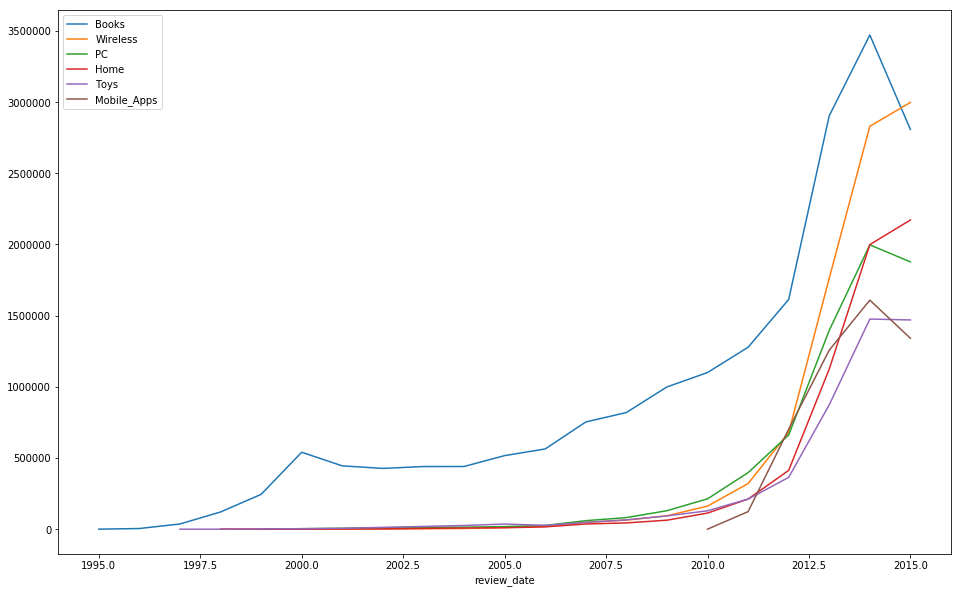

In [27]:
plot_temporal_evolution(chosen_categories, df_years)

For the recent categories the growth of reviews seems to be exponential. For books, we notice a slower growth. The plot reflects a big expection of Amazon after 2010.

### Number of categories by year

In [ ]:
df_final = df_years.fillna(0).astype(bool).sum(axis = 1)
df = pd.DataFrame(df_final)
df.columns = ['Categories']
df

###### Figure for the report (number of reviews and categories by year)

In [ ]:
fig_sub = plt.figure(figsize = (15,13))

# Divide the figure into a 2x1 grid, and give me the first section
ax1 = fig_sub.add_subplot(211)

# Divide the figure into a 2x1 grid, and give me the second section
ax2 = fig_sub.add_subplot(212)

df_years[['Books', 'PC', 'Home']].plot(kind='bar', ax=ax1)
df.plot(kind='bar', ax=ax2, width=0.3)

ax1.axes.set_title("Evolution of Amazon's reviews number",fontsize=25)
ax1.set_xlabel("")
ax1.set_ylabel("Number of Reviews", fontsize=18)

ax2.axes.set_title("Number of Amazon's categories over time",fontsize=25)
ax2.set_xlabel("Years", fontsize=18)
ax2.set_ylabel("Number of Categories", fontsize=18)

fig_sub.subplots_adjust(hspace=0.3)

In [ ]:
#Save figure
fig_sub.savefig("temporal_evolution_1.png")

### Number of products reviewed by year

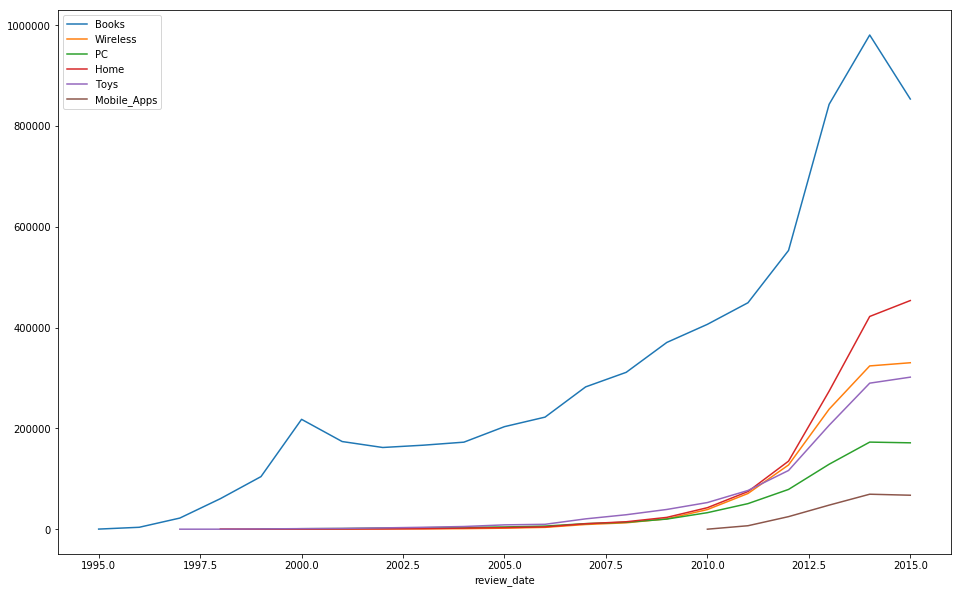

In [28]:
def count_products_by_year(category, df):
    df_read = read_DataFrame(category)
    df[category] = df_read.groupby(pd.DatetimeIndex(df_read['review_date']).year).product_parent.nunique()
    
products_years = temporal_analysis(chosen_categories, count_products_by_year)
plot_temporal_evolution(chosen_categories, products_years)

### Average rating per year

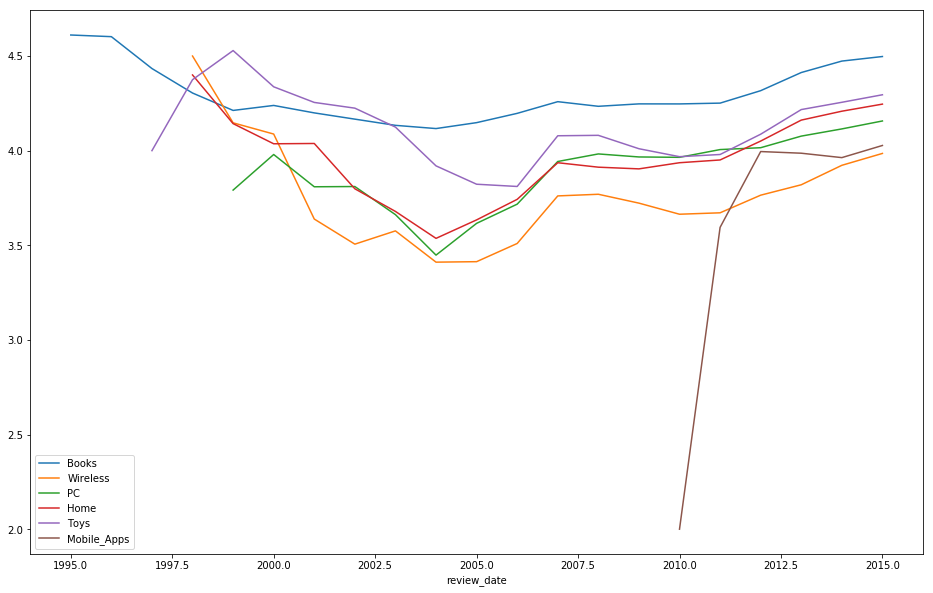

In [29]:
def rating_by_year(category, df):
    df_read = read_DataFrame(category)
    df[category] = df_read.groupby(pd.DatetimeIndex(df_read['review_date']).year).star_rating.mean()
    
rating_years = temporal_analysis(chosen_categories, rating_by_year)
plot_temporal_evolution(chosen_categories, rating_years)

There seems to be some decline in product ratings, customers are less satisifed with products? 

### Usefullness by year

In [30]:
def usefulness_by_year(category, df):
    df_read = read_DataFrame(category)
    df_read['usefulness'] = df_read.helpful_votes / df_read.total_votes
    df[category] = df_read.groupby(pd.DatetimeIndex(df_read['review_date']).year).usefulness.mean()
    
usefulness_years = temporal_analysis(chosen_categories, usefulness_by_year)


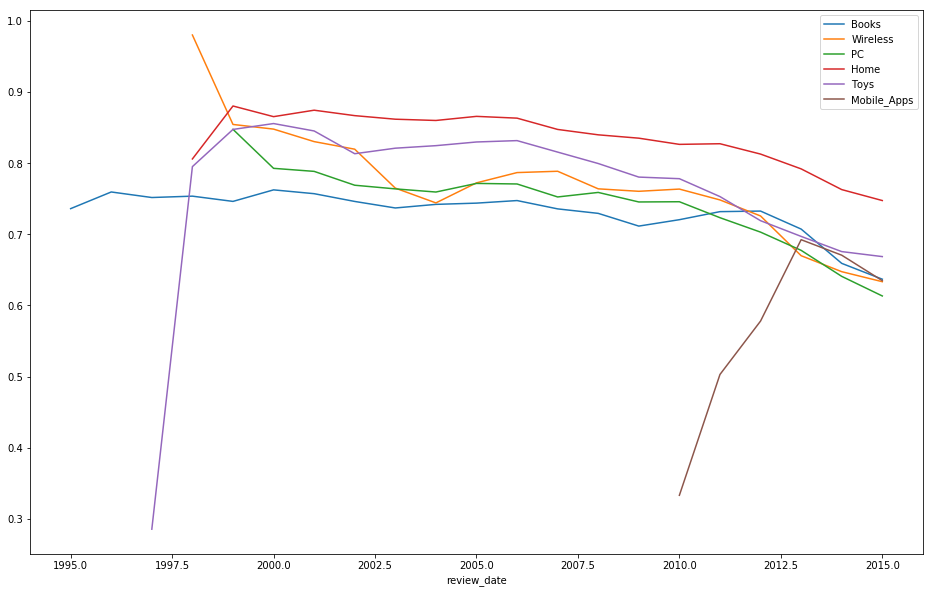

In [31]:
plot_temporal_evolution(chosen_categories, usefulness_years)

Are there more reviews but of lower quality?

## Analysis of books reviews

### Are helpful reviews related to star ratings?

In [32]:
df_books = read_DataFrame('Books')
df_books["helpful_rate"] = df_books["helpful_votes"] / df_books["total_votes"]
df_books.head()

,customer_id,review_id,product_parent,product_category,star_rating,helpful_votes,total_votes,review_date,helpful_rate
0,25933450,RJOVP071AVAJO,84656342,Books,5,0,0,2015-08-31,NaN
1,1801372,R1ORGBETCDW3AI,729938122,Books,5,0,0,2015-08-31,NaN
2,5782091,R7TNRFQAOUTX5,678139048,Books,5,0,0,2015-08-31,NaN
3,32715830,R2GANXKDIFZ6OI,712432151,Books,5,0,0,2015-08-31,NaN
4,14005703,R2NYB6C3R8LVN6,800572372,Books,5,2,2,2015-08-31,1.0


In [33]:
# keep only review with books_reviews with more than 5 votes
df_books_5 = df_books[df_books["total_votes"] > 5]
df_books_5.count()

customer_id         3992312
review_id           3992312
product_parent      3992312
product_category    3992312
star_rating         3992312
helpful_votes       3992312
total_votes         3992312
review_date         3992312
helpful_rate        3992312
dtype: int64

In [34]:
# groupby customer_id and filter to keep only customer with more than 5 reviews
df_books_5_5 = df_books_5.groupby("customer_id").filter(lambda r: len(r) > 5)

df_books_5_5.head()

,customer_id,review_id,product_parent,product_category,star_rating,helpful_votes,total_votes,review_date,helpful_rate
348,47904504,R2T328JHHK1NT0,3731425,Books,5,5,7,2015-08-31,0.714286
396,13129675,RH3DZDJG7350O,888190146,Books,4,12,13,2015-08-31,0.923077
438,52254797,RU9QBKQKRKNLK,953844844,Books,5,7,8,2015-08-31,0.875000
482,33356949,R32XJ7SV9MYTZN,906441903,Books,4,16,17,2015-08-31,0.941176
600,52413873,R25LRAO8Z4UGZO,592531765,Books,5,9,9,2015-08-31,1.000000


Correlation between helpful review and star rating:  0.5704854834055942


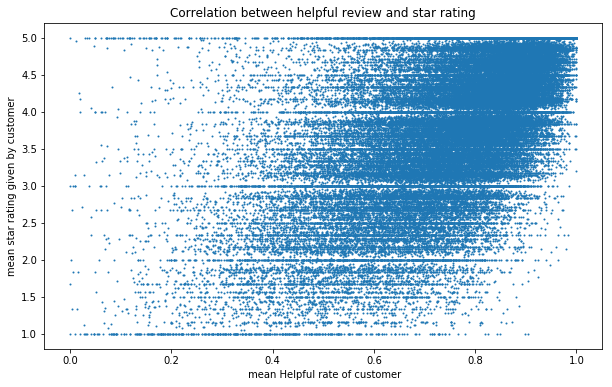

In [36]:
# mhr = mean helpful rate
mhr_by_customer = df_books_5_5.groupby("customer_id")["helpful_rate"].aggregate(np.mean)

# msr = mean star rating
msr_by_customer = df_books_5_5.groupby("customer_id")["star_rating"].aggregate(np.mean)

plt.figure(figsize=(10, 6))
plt.scatter(mhr_by_customer, msr_by_customer, s=1)
plt.xlabel(" mean Helpful rate of customer")
plt.ylabel("mean star rating given by customer")
plt.title("Correlation between helpful review and star rating")
print("Correlation between helpful review and star rating: ",np.corrcoef(mhr_by_customer, msr_by_customer)[0][1])

So, people are more likely to find a review helpful if the star rating corresponding is high. This could indicate a sort of bias or snowball effect.

## Statistical analysis of vary bad reviews

In [33]:
df_books_ref = df_books[(df_books['total_votes'] > 4)]

Let's choose reviews that have at least 5 votes an 0.0 helpful rate.

In [34]:
bad_df_books = df_books[(df_books['helpful_rate'] == 0.0) & (df_books['total_votes'] > 4)]
bad_df_books.count()

customer_id         111623
review_id           111623
product_parent      111623
product_category    111623
star_rating         111623
helpful_votes       111623
total_votes         111623
review_date         111623
helpful_rate        111623
dtype: int64

Let's compare the basic statistics of "bad reviews" and all the reviews in books category.

In [35]:
bad_df_books['star_rating'].describe()

count    111623.000000
mean          3.039508
std           1.598772
min           1.000000
25%           1.000000
50%           3.000000
75%           5.000000
max           5.000000
Name: star_rating, dtype: float64

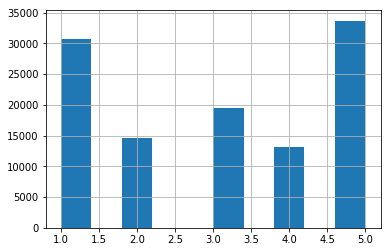

In [36]:
bad_df_books['star_rating'].hist()

In [ ]:
df_star = bad_df_books['star_rating']
c = Counter(df_star)

df_star_prop = pd.DataFrame(c, index=[0]).transpose().sort_index(axis=0)
df_star_prop.columns = ["Books"]
df_star_prop

In [37]:
df_books_ref['star_rating'].describe()

count    4.666782e+06
mean     3.833251e+00
std      1.489634e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: star_rating, dtype: float64

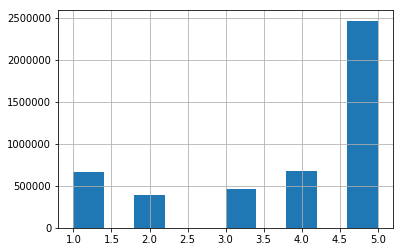

In [38]:
df_books_ref['star_rating'].hist()

In [ ]:
df_star_ref = df_books_ref['star_rating']
c_ref = Counter(df_star_ref)

df_star_proportion = pd.DataFrame(c_ref, index=[0]).transpose().sort_index(axis=0)
df_star_proportion.columns = ["Books"]
df_star_proportion

There are a lot of negative ratings in bad reviews. Other scores also appear, though. Considering all the reviews, the 5 star ratings are most common. Are bad reviews written mostly by unhappy customers and spammers (rating 5)?

###### Figure for the report (star rating)

In [ ]:
fig_star_comparison = plt.figure(figsize = (15,13))

# Divide the figure into a 2x1 grid, and give me the first section
ax1 = fig_star_comparison.add_subplot(211)

# Divide the figure into a 2x1 grid, and give me the second section
ax2 = fig_star_comparison.add_subplot(212)

df_star_proportion.plot(kind='bar', ax=ax1)
df_star_prop.plot(kind='bar', ax=ax2)

ax1.axes.set_title("Rating distribution for all reviews in Books category",fontsize=20)
ax1.set_xlabel("")
ax1.set_ylabel("Total number of reviews", fontsize=18)

ax2.axes.set_title("Rating distribution for reviews qualified as not useful in Books category",fontsize=20)
ax2.set_xlabel("Rating", fontsize=18)
ax2.set_ylabel("Number of not useful reviews", fontsize=18)

fig_star_comparison.subplots_adjust(hspace=0.25)

In [ ]:
#Save figure
fig_star_comparison.savefig("star_comparison_2.png")

Further analysis:

In [39]:
#Number of reviews per customer
bad_df_books['customer_id'].count()/ bad_df_books['customer_id'].nunique()

1.0893130739428716

In [40]:
#Number of reviews per customer
df_books_ref['customer_id'].count()/ df_books_ref['customer_id'].nunique()

1.9522821056013493

On average, only one bad review is written per customer, while two "regular" reviews per customer. The following explanation is possible: an incident happens (a damaged product?) and the customer unleashes his anger by writing a review. Then, others notice it is not a well-balanced review.

In [45]:
bad_df_books.groupby('customer_id').size().describe()

count    102471.000000
mean          1.089313
std           0.888277
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         140.000000
dtype: float64

In [46]:
df_books_ref.groupby('customer_id').size().describe()

count    2.390424e+06
mean     1.952282e+00
std      1.774935e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.004800e+04
dtype: float64

We check the distribution of number of bad reviews per customer.

Text(0,0.5,'Number of customers')

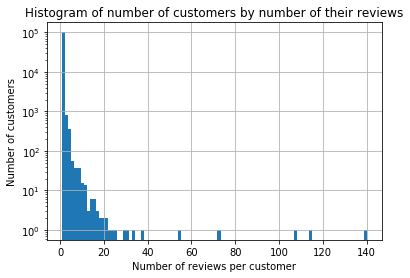

In [44]:
fig, ax = plt.subplots()
bad_df_books.groupby('customer_id').size().hist(ax=ax, bins=100)
ax.set_yscale('log')
ax.set_title("Histogram of number of customers by number of their reviews")
ax.set_xlabel("Number of reviews per customer")
ax.set_ylabel("Number of customers")


There are a few customers writing a lot of bad reviews. Can they be spammers that produce serial reviews?

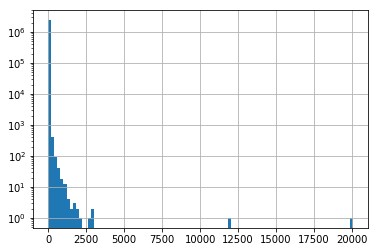

In [48]:
fig, ax = plt.subplots()
df_books_ref.groupby('customer_id').size().hist(ax=ax, bins=100)
ax.set_yscale('log')

There are only a few customers that produce a lot of really bad reviews. The outliers can represent "fake reviews" and "fake reviewers". In the plot of reference book reviews there are also strong outliers. It seems unlikely that a person can write 20000 genuine reviews. Let's check if this is the "bad guy".

In [59]:
bad_guys = bad_df_books.groupby('customer_id').filter(lambda x: len(x)> 100)['customer_id'].unique()
bad_guys

array([35985708, 50122160, 43530996])

In [61]:
df_books_ref.groupby('customer_id').filter(lambda x: len(x)> 2500)['customer_id'].unique()

array([50732546, 36642996, 50776149, 52615377, 50122160])

So we found one customer: 50122160 who is spamming and we were able to detect him by checking the "usefulness score".

## Text mining

Based on the previous analysis, it is highly probable that the 'bad guy' will give a rating that is 'far' from the mean of the ratings for a given product. The goal here is make our analysis more robust and to ensure the the review is actually bad.

## Sentiment analysis

To perform sentiment analysis we'll use __nltk__ library.

Note: we'll work on Wireless's category.

In [ ]:
import nltk.data
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

import seaborn as sns

Folder with the data containing review's body:

In [ ]:
TEXT_PARQUET_DIR = './text_parquet/'

In [ ]:
#Text parquet link to the desired category (using complete path)
df_wireless = pd.read_parquet(TEXT_PARQUET_DIR+'Wireless_text.parquet.gzip/'+'part-00000-321618fb-c8f4-49c2-a9bb-a4afbf170e56-c000.gz.parquet', 
                engine='fastparquet')
df_wireless.head()

In [ ]:
#Analyzer initialisation
analyzer = SentimentIntensityAnalyzer()

In [ ]:
#Compute the compound score for each review
def aggregate_score(txt):
    """
    Compute the compound score
    """
    agg_score = analyzer.polarity_scores(txt)
    return agg_score['compound']

To reduce computation time, we'll work on a subset of the original dataset.

In [ ]:
df_wireless_sampled = df_wireless.iloc[::100, :]
df_wireless_sampled.head()

In [ ]:
#Compute the compound score for each review
df_wireless_sampled['compound_score'] = df_wireless_sampled['review_body'].apply(aggregate_score)
df_wireless_sampled.head()

In [ ]:
df_wireless_sampled['compound_score'].hist()
plt.xlabel('Sentiment compound score')
plt.ylabel('Number of reviews')

Now we'll compare the obtained results with the content of **bad** reviews.

In [ ]:
df_wireless_features = read_DataFrame('Wireless')
df_wireless_features["helpful_rate"] = df_wireless_features["helpful_votes"] / df_wireless_features["total_votes"]
df_wireless_features.head()

Keep only review with books_reviews with more than 5 votes:

In [ ]:
df_wireless_features_5 = df_wireless_features[(df_wireless_features['helpful_rate'] == 0.0) & (df_wireless_features['total_votes'] > 5)]
df_wireless_features_5.head()

In [ ]:
df_wireless_bad = pd.merge(df_wireless_sampled, df_wireless_feature_5, how='inner', on="review_id")
df_wireless_bad.head()

In [ ]:
df_wireless_bad['compound_score'].hist()

###### Figure for the report (sentiment)

In [ ]:
fig_sentiment = plt.figure(figsize=(12,8))

# Divide the figure into a 2x1 grid, and give me the first section
ax_1 = fig_sentiment.add_subplot(211)

# Divide the figure into a 2x1 grid, and give me the second section
ax_2 = fig_sentiment.add_subplot(212)


sns.distplot(df_wireless_sampled['compound_score'], ax=ax_1, kde = False, bins=15, hist_kws=dict(edgecolor="w", linewidth=1))

ax_1.axes.set_title("Sentiment distribution for Wireless category",fontsize=15)
ax_1.set_xlabel("",fontsize=15)
ax_1.set_ylabel("Number of reviews",fontsize=15)

sns.distplot(df_wireless_bad['compound_score'], ax=ax_2, kde = False, bins=15, hist_kws=dict(edgecolor="w", linewidth=1))

ax_2.axes.set_title("Sentiment distribution for supposed bad reviews in Wireless category",fontsize=15)
ax_2.set_xlabel("Compound score",fontsize=15)
ax_2.set_ylabel("Number of reviews",fontsize=15)

fig_sentiment.subplots_adjust(hspace=0.3)

In [ ]:
#Save figure
fig_sentiment.savefig("sentiment.png")